<a href="https://colab.research.google.com/github/sawao7/seq2seq_translation/blob/main/sawao_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
!git clone https://github.com/odashi/small_parallel_enja.git

Cloning into 'small_parallel_enja'...
remote: Enumerating objects: 35, done.
remote: Total 35 (delta 0), reused 0 (delta 0), pack-reused 35
Unpacking objects: 100% (35/35), done.


In [ ]:
with open("/content/drive/MyDrive/DataSets/Translate/split/dev", "r") as f:
  dev = f.readlines()
with open("/content/drive/MyDrive/DataSets/Translate/split/test", "r") as f:
  test = f.readlines()
with open("/content/drive/MyDrive/DataSets/Translate/split/train", "r") as f:
  train = f.readlines()

In [ ]:
def format_list(list):
  return [re.sub("\n","",s).split("\t") for s in list]

def AddEndAndStart(text):
  return "<start>" + text + "<end>"

def BuildTokenizer(texts):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='\n', oov_token="<unk>")
  tokenizer.fit_on_texts(texts)
  return tokenizer

def Texts2Sequences(tok, train_texts, test_texts):
  train_sequences = tok.texts_to_sequences(train_texts)
  # valid_sequences = tok.texts_to_sequences(valid_texts)
  test_sequences = tok.texts_to_sequences(test_texts)
  
  padded_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding="post")

  return padded_train_sequences, test_sequences

In [ ]:
dev = format_list(dev)
test = format_list(test)
train = format_list(train)
# df_dev = pd.DataFrame(dev, columns = ["英語","日本語"])
# df_test = pd.DataFrame(test, columns = ["英語","日本語"])
# df_train = pd.DataFrame(train, columns = ["英語","日本語"])

In [ ]:
# train_ja = []
# train_en = []
# test_ja = []
# test_en = []

# for i,x in train:
#   train_ja.append(AddEndAndStart(x))
#   train_en.append(AddEndAndStart(i))

# for i,x in test:
#   test_ja.append(AddEndAndStart(x))
#   test_en.append(AddEndAndStart(i))

def Preprocess(text):
  text = "<start> "+text+" <end>"
  text = text.replace("\n", " ")
  text = re.sub(r"[' ']+", " ", text)
  return text

def Read(filename):
  new_lines = []
  with open(filename, "r") as f:
    lines = f.readlines()
  for line in lines:
    new_lines.append(Preprocess(line))
  return new_lines

DIR_NAME = "small_parallel_enja/"
train_ja = Read(DIR_NAME+"train.ja")
train_en = Read(DIR_NAME+"train.en")

valid_ja = Read(DIR_NAME+"dev.ja")
valid_en = Read(DIR_NAME+"dev.en")

test_ja = Read(DIR_NAME+"test.ja")
test_en = Read(DIR_NAME+"test.en")

In [ ]:
test_ja

['<start> 彼 ら は つい に それ が 真実 だ と 認め た 。 <end>',
 '<start> 彼 は 水泳 が 得意 で は な かっ た 。 <end>',
 '<start> 彼 は お 姉 さん に 劣 ら ず 親切 だ 。 <end>',
 '<start> １０ 時 前 に 戻 ら な けれ ば な ら な い 。 <end>',
 '<start> 成功 を 祈 る わ 。 <end>',
 '<start> 彼女 は 私 たち の 隣 の 家 に す ん で い る 。 <end>',
 '<start> あなた に 返事 を し よ う と し て い る ところ で す 。 <end>',
 '<start> 私 は 刹那 的 な 生き 方 を し て い る 人間 で す 。 <end>',
 '<start> この 試合 は いただ き だ 。 <end>',
 '<start> こんな こと を し た 理由 を 言 い な さ い 。 <end>',
 '<start> 彼女 は その 先生 が 好き で す 。 <end>',
 '<start> それ が 仕事 で す 。 <end>',
 '<start> この 靴 は 二 年 も つ で しょ う 。 <end>',
 '<start> 彼 は 自分 の 代わり に 息子 を その 会合 に 出席 さ せ た 。 <end>',
 '<start> 行 か な い 理由 を 述べ なさ い 。 <end>',
 '<start> 一 日 の 仕事 が 終わ る と 皆 家路 を 急 ぐ 。 <end>',
 '<start> 私 は 彼女 の 顔 を まとも に 見 る こと が な かっ た 。 <end>',
 '<start> 日曜 日 の 朝 に 教会 に 行 く 人 も い る 。 <end>',
 '<start> 私 は 時計 を ２ 分 進め な けれ ば な ら な い 。 <end>',
 '<start> あれ は 私 が 昨日 会 っ た 少年 で す 。 <end>',
 '<start> １０ 年 は 待 つ に は 長 い 時間 だ 。 <end>',
 '<start> 私 は 東京 で 偶然 彼 に 会 っ た 。 <end>'

In [ ]:
# train_ja = train_ja[0:100000]
# train_en = train_en[0:100000]

In [ ]:
ja_tokenizer = BuildTokenizer(train_ja)
en_tokenizer = BuildTokenizer(train_en)

In [ ]:
train_ja_sequences, test_ja_sequences = Texts2Sequences(ja_tokenizer, train_ja, test_ja)
train_en_sequences, test_en_sequences = Texts2Sequences(en_tokenizer, train_en, test_en)

In [ ]:
def CreateEncoderModel(vocab_size):
  units = 128
  emb_layer = tf.keras.layers.Embedding(vocab_size, units, mask_zero=True, name="encdoder_emb")#padding有効にするために、mask_zero=True
  gru_layer  = tf.keras.layers.GRU(units, name="encdoder_gru")
  encoder_inputs = tf.keras.Input(shape=(None,), name="encdoder_inputs")
  outputs = emb_layer(encoder_inputs)
  outputs = gru_layer(outputs)
  
  encoder = tf.keras.Model(encoder_inputs, outputs)

  return encoder

def CreateDecoderModel(vocab_size):
  units = 128

  emb_layer = tf.keras.layers.Embedding(vocab_size, units, mask_zero=True, name="decdoder_emb")#padding有効にするために、mask_zero=True
  gru_layer  = tf.keras.layers.GRU(units, return_sequences=True, name="decdoder_gru")
  dense_layer = tf.keras.layers.Dense(vocab_size, activation="softmax", name="decdoder_outputs")

  decoder_inputs  = tf.keras.Input(shape=(None,), name="decdoder_inputs")
  decoder_hidden_states = tf.keras.Input(shape=(None,), name="decoder_hidden_states")

  outputs = emb_layer(decoder_inputs)
  gru_outputs = gru_layer(outputs, initial_state=decoder_hidden_states)
  outputs = dense_layer(gru_outputs)

  decoder = tf.keras.Model([decoder_inputs, decoder_hidden_states], [outputs, gru_outputs])

  return decoder

def CreateModel(seed, ja_vocab_size, en_vocab_size):
  tf.random.set_seed(seed)
  encoder = CreateEncoderModel(ja_vocab_size)
  decoder = CreateDecoderModel(en_vocab_size)

  encoder_inputs = tf.keras.Input(shape=(None,))
  decoder_inputs = tf.keras.Input(shape=(None,))

  encoder_outputs = encoder(encoder_inputs)
  decoder_outputs, gru_outputs = decoder([decoder_inputs, encoder_outputs])
  
  model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                )
  return model, encoder, decoder
  #評価方法はBLEU
def Evaluate(ja_texts, en_texts, encoder, decoder):
  score = 0.0
  for ja_text, en_text in zip(ja_texts, en_texts):
    predicted_text = Predict(ja_text, encoder, decoder)
    score += sentence_bleu([en_text.strip().split()], predicted_text.strip().split(), smoothing_function=SmoothingFunction().method4)
  return score/len(ja_texts)

def Predict(ja_text, encoder, decoder):
  #日本語文章が形態素解析されていない状態の場合は、MeCabを使ってください。
  #MeCabの使い方
  #m = MeCab.Tagger("-Owakati")
  #ja_text           = m.parse(ja_text).strip()
  
  sequence         = ja_tokenizer.texts_to_sequences([ja_text.strip()])
  sequence         = np.array(sequence)
  encoder_outputs = encoder(sequence)

  decoder_hidden_states = encoder_outputs
  decoder_inputs = np.array(en_tokenizer.texts_to_sequences([["<start>"]]))

  #20回で打ち切り
  ans = "<start>"
  for _ in range(20):
    prediction, decoder_hidden_states = decoder([decoder_inputs, tf.reshape(decoder_hidden_states, [1, -1])])
    prediction_id = tf.argmax(prediction, axis=-1)[0][0].numpy()
    word = en_tokenizer.sequences_to_texts([[prediction_id]])
    decoder_inputs = np.reshape(np.array(prediction_id), [-1, 1])
    ans += " "+word[0]
    if word[0]=="<end>":
      break
  return ans

In [ ]:
best_model, best_encoder, best_decoder = CreateModel(123, len(ja_tokenizer.word_index)+1, len(en_tokenizer.word_index)+1)

Epoch 1/3
1563/1563 [==============================] - 54s 34ms/step - loss: 1.6603
Epoch 2/3
1563/1563 [==============================] - 54s 34ms/step - loss: 1.4408
Epoch 3/3
1563/1563 [==============================] - 54s 35ms/step - loss: 1.2745


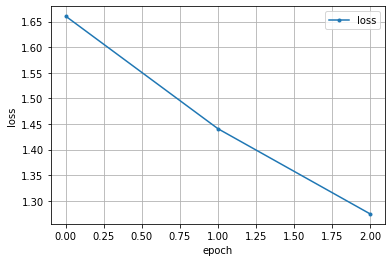

In [ ]:
# history = model.fit(X_train, y_train, epochs=75, batch_size=16,
                    # verbose=1, validation_data=(X_test, y_test))
history = best_model.fit([train_ja_sequences, train_en_sequences[:, :-1]], train_en_sequences[:, 1:], batch_size=32, epochs=3)
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
# plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
best_model.fit([train_ja_sequences, train_en_sequences[:, :-1]], train_en_sequences[:, 1:], batch_size=32, epochs=100)

bleu_score = Evaluate(test_ja, test_en, best_encoder, best_decoder)
print("bleu on test_dataset:")
print(bleu_score)



Epoch 1/5
1563/1563 [==============================] - 73s 42ms/step - loss: 2.6568
Epoch 2/5
1563/1563 [==============================] - 65s 42ms/step - loss: 1.7143
Epoch 3/5
1563/1563 [==============================] - 66s 42ms/step - loss: 1.4727
Epoch 4/5
1563/1563 [==============================] - 67s 43ms/step - loss: 1.2924
Epoch 5/5
1563/1563 [==============================] - 68s 43ms/step - loss: 1.1528
bleu on test_dataset:
0.19435027906746655


In [ ]:
histrory

NameError: ignored

In [ ]:
bleu_score = Evaluate(test_ja, test_en, best_encoder, best_decoder)
print("bleu on test_dataset:")
print(bleu_score)

bleu on test_dataset:
0.18095887451718753


In [ ]:
Predict("<start>エミ は 幸せ そう に 見え ま せん 。<end>",best_encoder,best_decoder)

'<start> treats shelves contract visa magazine greek location strongly 50,000 pillow trifles sunrise buy buy kenny bursting compelled compelled old fantasy'

In [ ]:
type(train_ja_sequences)

numpy.ndarray

In [ ]:
test_en[0:5]

['<start> i can t tell who will arrive first . <end>',
 '<start> many animals have been destroyed by men . <end>',
 '<start> i m in the tennis club . <end>',
 '<start> emi looks happy . <end>',
 '<start> please bear this fact in mind . <end>']

In [ ]:
train_en[0:5]

['<start> i can t tell who will arrive first . <end>',
 '<start> many animals have been destroyed by men . <end>',
 '<start> i m in the tennis club . <end>',
 '<start> emi looks happy . <end>',
 '<start> please bear this fact in mind . <end>']

In [ ]:
len(train_en)

50000

In [ ]:
len(test_en)

50000

In [ ]:
len(test_ja)

500

In [ ]:
len(test_en)

500